In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import graphviz

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn import tree



#### Load the training data and the test data

In [25]:
X_train = pd.read_csv('data/x_train.csv')
y_train = pd.read_csv('data/y_train.csv')

X_test = pd.read_csv('data/x_test.csv')
y_test = pd.read_csv('data/y_test.csv')

#### Discard the label from the response column

In [26]:
y_train = y_train['high_humidity_label']
y_test = y_test['high_humidity_label']

#### Print a 5 row table to visualize the data

In [27]:
X_train[:5]

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am
0,918.300000,64.004000,71.700000,6.621342,82.500000,8.030615,0.00,0.0
1,920.740000,59.090000,180.000000,8.992499,194.000000,10.759681,0.08,520.0
2,917.290000,78.206000,51.500000,7.180577,68.000000,9.193823,0.00,0.0
3,915.104853,80.661032,214.407657,1.535364,116.843001,2.411888,0.00,0.0
4,916.500000,71.042000,102.300000,2.415895,49.100000,3.221194,0.00,0.0


In [28]:
y_train[:5]

0    0
1    1
2    1
3    0
4    1
Name: high_humidity_label, dtype: int64

## Subtask 2.1 Weather Prediction Using Decision Trees


## Subtask 2.1 Part 1
Write a description of the dataset provided, including, for instance, how many features there are, the number of classes, examples per class in training and testing sets, and so on.

The data contains 8 attributes, Formalization of Input Attributes:

$P_{9am}:$ Air pressure at 9 Am.<br/>
$T_{9am}:$ Air temperature at 9 am.<br/>
$AWD_{9am}:$ Average wind direction at 9 am.<br/>
$AWS_{9am}:$ Average wind speed at 9 am.<br/>
$MWD_{9am}:$ Maximum wind direction at 9 am.<br/>
$MWS_{9am}:$ Maximum wind speed at 9 am.<br/>
$RA_{9am}:$ Rain accumulation at 9 am.<br/>
$RD_{9am}:$ Rain duration at 9 am.<br/>


### Data description and insights
**1.Initially we make sure that the data is clean and ready to be used in the decision tree**
1. The data doesn't contain any null values
2. Count the zeros in each dimension
3. Count the classes and make sure they are balanced


In [29]:
import pandas as pd

# Check for null values
null_value_counts_X = X_train.isnull().sum()
null_value_counts_y = y_train.isnull().sum()


# create and print summary
summary_data = {
    'Null Value Counts (X)': null_value_counts_X,
    'Null Value Counts (y)': null_value_counts_y,
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)


                        Null Value Counts (X)  Null Value Counts (y)
air_pressure_9am                            0                      0
air_temp_9am                                0                      0
avg_wind_direction_9am                      0                      0
avg_wind_speed_9am                          0                      0
max_wind_direction_9am                      0                      0
max_wind_speed_9am                          0                      0
rain_accumulation_9am                       0                      0
rain_duration_9am                           0                      0


**Count the classes and make sure they are balanced**
We can see that we have two classes 0, and 1 with both classes in the dataset being balanced, which signifies that there will be no bias when training the model with the data

In [30]:
y_train.value_counts()

high_humidity_label
0    376
1    368
Name: count, dtype: int64

**2.We plot the data for visualization and possible insights**

A box plot although simple but powerful, it gives us insights about the data varaince, and allows us to detect if there is any corelation between different attributes.


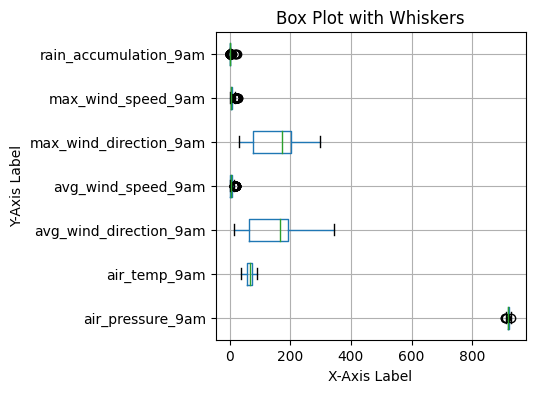

In [31]:
def box_plot(columns):
    plt.figure(figsize=(4, 4)) 
    X_train.boxplot(column=columns, vert=False)
    plt.title('Box Plot with Whiskers')
    plt.xlabel('X-Axis Label')
    plt.ylabel('Y-Axis Label')
    plt.show()
    
box_plot(['air_pressure_9am',
          'air_temp_9am',
          'avg_wind_direction_9am',
          'avg_wind_speed_9am',
          'max_wind_direction_9am',
          'max_wind_speed_9am',
          'rain_accumulation_9am'])

Given the box plot, we can see that both `avg_wind_direction_9am` and `max_wind_direction_9am` are correlated, also
`avg_wind_speed_9am` and `max_wind_speed_9am` are correlated and almost the same

#### Helper functions
I created two helper functions one to predict and print the accuracy, the second to draw and save the decision tree

In [32]:
def predict_and_print_accuracy(x_test, y_test, decision_tree):
    y_pred = decision_tree.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    
def draw_and_save_decision_tree(data):
    dot_data = export_graphviz(decision_tree, out_file=None, 
                                feature_names=data.columns,  
                                class_names=['class_0', 'class_1'],
                                filled=True, rounded=True,  
                                special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.render("decision_tree")
    graph.view("decision_tree")




## Subtask 2.1 Part 2
Build a decision tree using part of the provided dataset for training and then evaluate your decision tree using part of the provided dataset to measure the decision tree accuracy. Your answer to this item should contain a description of steps you followed to propose your decision tree model, including how to import data, how to train a decision tree, the parameter settings of the algorithm, and so on.

### 1.Importing the data
I used the function read_csv to read the data, sperating the training data from the test data for both the input 
attributes and the classes (x, y)

In [33]:
X_train = pd.read_csv('data/x_train.csv')
y_train = pd.read_csv('data/y_train.csv')

X_test = pd.read_csv('data/x_test.csv')
y_test = pd.read_csv('data/y_test.csv')

### 2.Training the classifier and parameter choice

##### 1.1 `min_samples_split` or `min_samples_leaf` 
The parameters `min_samples_split` and `min_samples_leaf` play a vital role in decision tree algorithms. They ensure that multiple samples influence every decision in the tree by controlling which splits will be considered. A very small number for these parameters can lead to overfitting, where the tree captures noise in the data rather than general patterns. On the other hand, a large number will prevent the tree from effectively learning from the data. In my initial configuration, I set `min_samples_split` to 5, following the recommendation from Scikit-learn.

##### 1.2.  `max_depth` 
The `max_depth` parameter determines the maximum depth of the decision tree. I chose a value of 20, indicating that the tree can have a maximum of 20 levels from the root node. This value was selected based on the complexity of the dataset and the desire to capture intricate patterns within the data.
##### 1.3. `random_state`
The `random_state` parameter controls the randomness of the estimator. Setting an initial value ensures reproducibility in the results. I started with a value of 16 for `random_state`, providing a seed for the random number generator. This consistent starting point allows for consistent results across different runs of the algorithm.
##### 1.4. `criterion`
The `criterion` parameter determines the split criterion used in the decision tree algorithm. I chose the entropy criterion, which measures the information gain at each split. Entropy is a measure of impurity in the data; minimising it results in a more homogenous and informative tree. By starting with entropy, the algorithm aimed to maximise information gain, leading to well-informed splits and, ultimately, a more accurate decision tree model.

In [34]:
decision_tree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=16, 
    max_depth=10, 
    max_leaf_nodes=10,
    min_samples_split=5).fit(X_train, y_train)
predict_and_print_accuracy(X_test, y_test, decision_tree)


Accuracy: 80.94%


## Subtask 2.1 Part 3
Evaluate the decision tree of the previous item, in terms of i) its prediction accuracy; ii) how dependent it is on parameter setting (e.g., maximum number of leaf nodes); iii) any other relevant characteristics.

**Attempt 1:**
In this attempt we use the default parameters recommended by Scikit learn, train our classifier, print accuracy and 
draw the decision tree

In [35]:
decision_tree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=100, 
    max_depth=20, 
    max_leaf_nodes=10,
    min_samples_split=5).fit(X_train, y_train)

predict_and_print_accuracy(X_test, y_test, decision_tree)


Accuracy: 80.94%


In [36]:
draw_and_save_decision_tree(X_train)

**Attempt 2:**
In this attempt we tweak the parameters `min_samples_split`, `max_depth`, `random_state`, and `criterion`, `max_leaf_nodes` 
Increaseing the  `max_depth` beyond 20 didn't affect the model accuracy, decreasing it to 10 didn't affect the model accuracy neither. while increasing the `min_samples_split`  and `max_leaf_nodes` to 20 and 16 respectively raised the accuracy to 83.44%


In [37]:
decision_tree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=100, 
    max_depth=15, 
    max_leaf_nodes=15,
    min_samples_split=8).fit(X_train, y_train)

predict_and_print_accuracy(X_test, y_test, decision_tree)

Accuracy: 83.12%


In [38]:
draw_and_save_decision_tree(X_train)

**Attempt 3:**
In this attempt we tweak the parameters `min_samples_split`, `max_depth`, `random_state`, and `criterion`, `max_leaf_nodes` 
Increaseing the  `max_depth` beyond 20 didn't affect the model accuracy, decreasing it to 10 didn't affect the model accuracy neither. while increasing the `min_samples_split`  and `max_leaf_nodes` to 20 and 16 respectively raised the accuracy to 83.44%


In [39]:
X_train_reduced = X_train.drop(columns=['max_wind_speed_9am', 'max_wind_direction_9am'])
X_test_reduced = X_test.drop(columns=['max_wind_speed_9am', 'max_wind_direction_9am'])

decision_tree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=100, 
    max_depth=15, 
    max_leaf_nodes=15,
    min_samples_split=8).fit(X_train_reduced, y_train)

predict_and_print_accuracy(X_test_reduced, y_test, decision_tree)

Accuracy: 82.50%


In [40]:
draw_and_save_decision_tree(X_train_reduced)

------------------------------------------------------------

**Attempt 4:**
In this attempt we use a technique to limit the attributes values,
by assigning values to buckets for example values [1.44, 1.47, 1.5] can all lie in a bucket that has a value 1.5
we will observe how that affects the accuracy

In [41]:

def discretize(x_train, x_test):
    bin_values = np.arange(2, 41)  
    accuracies = []

    for bins in bin_values:
        discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform', subsample=None)

        X_binned_train = discretizer.fit_transform(x_train)
        X_binned_test = discretizer.transform(x_test)

        decision_tree = DecisionTreeClassifier(criterion="entropy",
                                               random_state=100, 
                                               max_depth=15, 
                                               max_leaf_nodes=15,
                                               min_samples_split=8)
        decision_tree.fit(X_binned_train, y_train)

        y_pred = decision_tree.predict(X_binned_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    plot_accuracy(bin_values, accuracies, 'a', 'b')

def plot_accuracy(x, y, x_label, y_label):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x)
    plt.grid(True)
    plt.show()



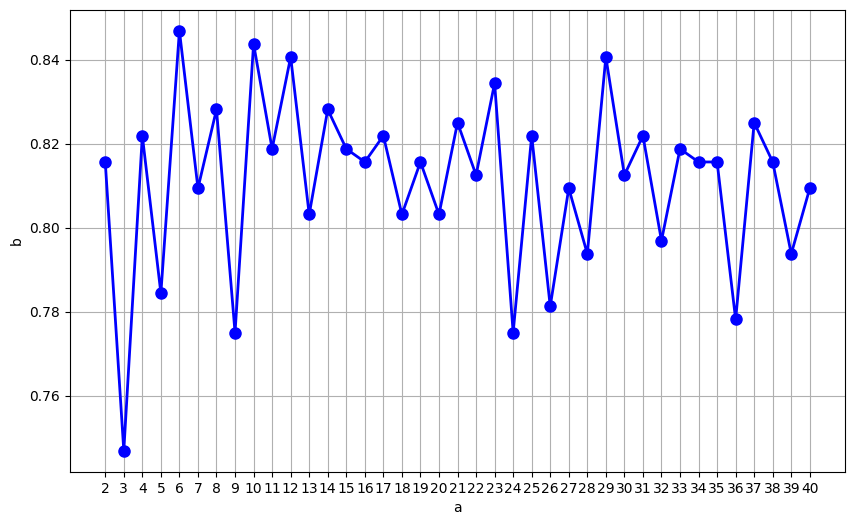

Accuracy: 84.69%


In [42]:
discretize(X_train_reduced, X_test_reduced)


discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform', subsample=None)

X_binned_train = discretizer.fit_transform(X_train_reduced)
X_binned_test = discretizer.transform(X_test_reduced)

decision_tree = DecisionTreeClassifier(criterion="entropy",
                                       random_state=100, 
                                       max_depth=15, 
                                       max_leaf_nodes=15,
                                       min_samples_split=8)
decision_tree.fit(X_binned_train, y_train)

predict_and_print_accuracy(X_binned_test, y_test, decision_tree)


In [43]:
def draw_and_save_decision_tree(data, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, 
                                feature_names=feature_names,  
                                class_names=['class_0', 'class_1'],
                                filled=True, rounded=True,  
                                special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.render("decision_tree")
    graph.view("decision_tree")
draw_and_save_decision_tree(X_binned_train, feature_names=X_train_reduced.columns)


Observing the discretization process line chart, we can observe that having the buckets count of 6 
gives us the highest accuracy, we use our function predict_and_print_accuracy(X_binned_test, y_test)
to obtain the accuracy which is 84.69%, a better accuracy than the previous attempts


### 2.Choosing and Monitoring Entropy

<p>In general, the entropy of a random variable V with values vk, each with probability
P(vk), is defined as</p>

$$
H(V) = -\sum_{k} P(v_k) \log_2 1/P(v_k)
$$
In each new split in the decision tree we are seeking the split that acheives the minimum entropy, since a lower entropy means a higher node purity, i.e more information is conveyed

the entropy of a Boolean random variable that is true with
probability q:
$$B(q) = -(q \log_2 q + (1 - q) \log_2(1 - q))$$

A randomly chosen example from the training set has the kth value for the attribute with
probability (pk + nk)/(p + n), so the expected entropy remaining after testing attribute A is
$$\text{Remainder}(A) = \sum_{k=1}^{d} \frac{p_k + n_k}{p + n} B\left(\frac{p_k}{p_k + n_k}\right)
$$

Having the highest entropy at each split , means that the inforamtion gain is maximized, i.e we will be expecting 
in our decision tree to have the root of the tree with the highest information gain and then that gain will 
decrease as we progress towards the leaf
$$\text{Gain}(A) = B\left(\frac{p}{p+n}\right) - \text{Remainder}(A)$$


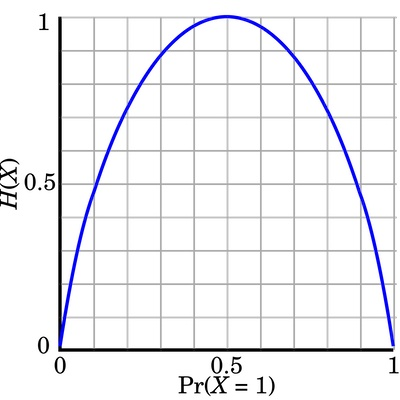